# Ready

## Import library

In [ ]:
!pip install -q scikit-plot

In [ ]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cv2
import dlib
import urllib

from google.colab import drive
from google.colab.patches import cv2_imshow

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

import scikitplot as skplt

from skimage import feature

import pickle
import joblib

import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


## Setting

In [ ]:
dir_dataset = '/content/drive/MyDrive/PYTHON/CV/DoAn/Dataset'

## Read Data

In [ ]:
df_test = pd.read_csv(os.path.join(dir_dataset, 'csv', 'test.csv'))

In [ ]:
lb_encoder = LabelEncoder()
lb_encoder.fit(df_test['label'])

df_test['label'] = lb_encoder.fit_transform(df_test['label'])

In [ ]:
df_test['images'] = [np.array([int(value) for value in img.split(' ')], dtype='uint8').reshape(48, 48) for img in df_test['images']]

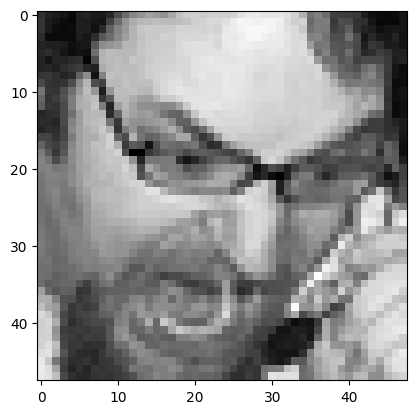

In [ ]:
plt.imshow(df_test['images'][0], cmap='gray')

## Calculate HOG

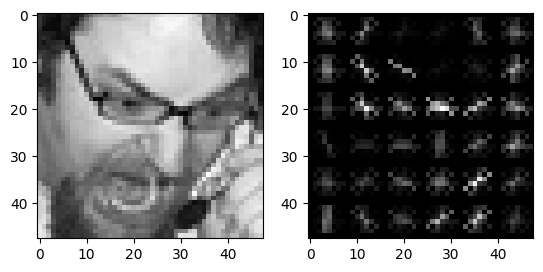

In [ ]:
img = df_test['images'][0]
hog, hog_img = feature.hog(img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), block_norm='L2-Hys', visualize=True, transform_sqrt=True)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(img, cmap='gray')
ax2.imshow(hog_img, cmap='gray')

In [ ]:
df_test_hog = pd.DataFrame(columns=['label', 'hog'])
for index in range(len(df_test)):
  img = df_test['images'][index]
  label = df_test['label'][index]

  hog, _ = feature.hog(img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), block_norm='L2-Hys', visualize=True, transform_sqrt=True)
  df_test_hog.loc[len(df_test_hog)] = (label, hog)

## Keypoint

In [ ]:
threshold = 0.04

gray = df_test['images'][0]

gray = np.float32(gray)
mask = gray.copy()

corners = cv2.cornerHarris(gray, 2, 3, 0.05)
corners = cv2.dilate(corners, None)

mask[True] = 255
mask[corners > threshold * corners.max()]= 0

(-0.5, 47.5, 47.5, -0.5)

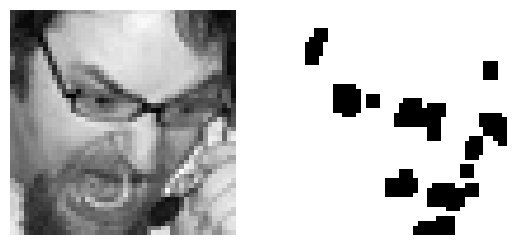

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.imshow(gray, cmap='gray')
ax1.axis('off')

ax2.imshow(mask, cmap='gray')
ax2.axis('off')

In [ ]:
def harris(img, threshold):

  # modify the data type setting to 32-bit floating point
  mask = np.float32(gray)
  # apply the cv2.cornerHarris method to detect the corners
  corners = cv2.cornerHarris(img, 2, 3, 0.05)
  #result is dilated for marking the corners
  corners = cv2.dilate(corners, None)

  mask[True] = 1
  mask[corners > threshold * corners.max()]= 0

  return mask

In [ ]:
threshold = 0.04

df_test_kp = pd.DataFrame(columns=['label', 'keypoint'])
for index in range(len(df_test)):
  img = df_test['images'][index]
  label = df_test['label'][index]

  keypoint = harris(img, threshold)
  df_test_kp.loc[len(df_test_kp)] = (label, keypoint)

In [ ]:
df_test_kp.head()

,label,keypoint
0,0,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,..."
1,0,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,..."
2,0,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,..."
3,0,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,..."
4,0,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,..."


## Data-preprocessing

In [ ]:
X_test = np.array([img for img in df_test['images'].values])
y_test = df_test['label'].values

X_test_hog = np.array([hog for hog in df_test_hog['hog'].values])
y_test_hog = df_test_hog['label'].values

X_test_kp = np.array([kp for kp in df_test_kp['keypoint'].values])
y_test_kp = df_test_kp['label'].values

In [ ]:
# Normalize
X_test = np.array([[[x/255 for x in row] for row in img] for img in X_test])

In [ ]:
# Convert to Tensor
X_test_tensor = torch.from_numpy(X_test.reshape(X_test.shape[0], 1, 48, 48)).float()
y_test_tensor = torch.from_numpy(y_test)

X_test_hog_tensor = torch.from_numpy(X_test_hog).float()
y_test_hog_tensor = torch.from_numpy(y_test_hog)

X_test_kp_tensor = torch.from_numpy(X_test_kp).float()
y_test_kp_tensor = torch.from_numpy(y_test_kp)

In [ ]:
# Convert to Tensor Dataset
test_tensor = TensorDataset(X_test_tensor, y_test_tensor)

test_hog_tensor = TensorDataset(X_test_hog_tensor, y_test_hog_tensor)

test_kp_tensor = TensorDataset(X_test_kp_tensor, y_test_kp_tensor)

In [ ]:
test_loader = DataLoader(test_tensor)

test_hog_loader = DataLoader(test_hog_tensor)

test_kp_loader = DataLoader(test_kp_tensor)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [ ]:
acc_models = dict()

In [ ]:
acc_models

{}

# KNN

In [ ]:
knn_models = dict()

## Image

### Euclidean

In [ ]:
knn_img = dict()

In [ ]:
knn_euc = pickle.load(open('/content/drive/MyDrive/PYTHON/CV/DoAn/checkpoint/model/knn_image_euc.pkl', 'rb'))

score_per_K = pickle.load(open('/content/drive/MyDrive/PYTHON/CV/DoAn/checkpoint/loss/knn_image_euc.pkl', 'rb'))

(0.0, 1.0)

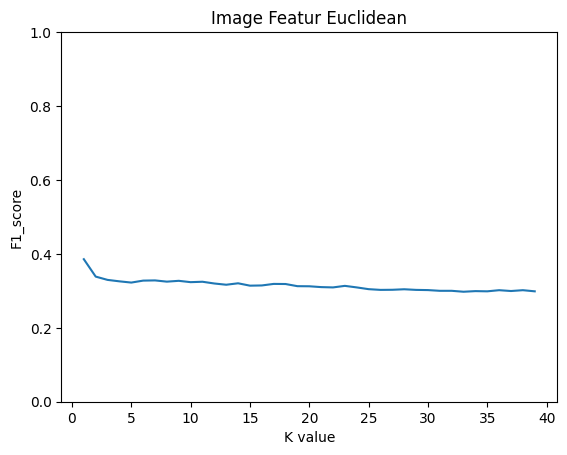

In [ ]:
plt.plot(range(1, len(score_per_K)+1), score_per_K)
plt.xlabel('K value')
plt.ylabel('F1_score')
plt.title('Image Featur Euclidean')
plt.ylim(0, 1)

              precision    recall  f1-score   support

       angry       0.33      0.29      0.31       958
     disgust       0.37      0.58      0.45       111
        fear       0.38      0.37      0.37      1024
       happy       0.44      0.39      0.41      1774
     neutral       0.30      0.41      0.35      1233
         sad       0.35      0.30      0.32      1247
    surprise       0.61      0.59      0.60       831

    accuracy                           0.39      7178
   macro avg       0.40      0.42      0.40      7178
weighted avg       0.40      0.39      0.39      7178



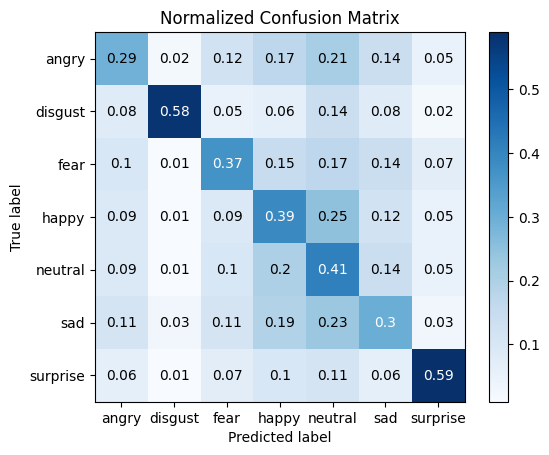

In [ ]:
y_test_pred = knn_euc.predict(X_test.reshape(X_test.shape[0], -1))

skplt.metrics.plot_confusion_matrix(lb_encoder.inverse_transform(y_test), lb_encoder.inverse_transform(y_test_pred), normalize=True)
print(classification_report(lb_encoder.inverse_transform(y_test), lb_encoder.inverse_transform(y_test_pred)))

knn_img['euclidean'] = f1_score(y_test, y_test_pred, average='micro')

### Cosine


In [ ]:
knn_cos = pickle.load(open('/content/drive/MyDrive/PYTHON/CV/DoAn/checkpoint/model/knn_image_cos.pkl', 'rb'))

score_per_K = pickle.load(open('/content/drive/MyDrive/PYTHON/CV/DoAn/checkpoint/loss/knn_image_cos.pkl', 'rb'))

(0.0, 1.0)

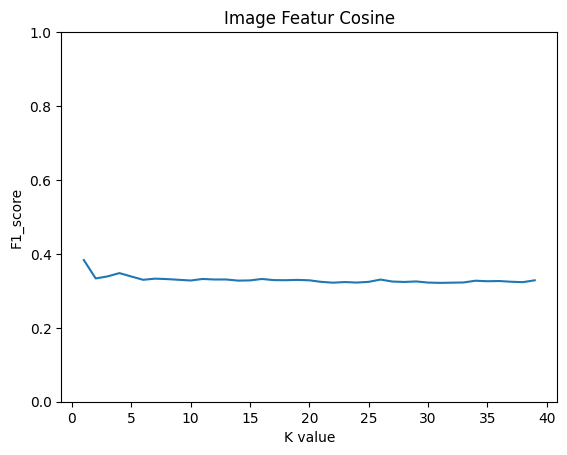

In [ ]:
plt.plot(range(1, len(score_per_K)+1), score_per_K)
plt.xlabel('K value')
plt.ylabel('F1_score')
plt.title('Image Featur Cosine')
plt.ylim(0, 1)

              precision    recall  f1-score   support

       angry       0.35      0.30      0.32       958
     disgust       0.37      0.57      0.45       111
        fear       0.35      0.37      0.36      1024
       happy       0.44      0.41      0.42      1774
     neutral       0.31      0.40      0.35      1233
         sad       0.37      0.29      0.32      1247
    surprise       0.53      0.59      0.56       831

    accuracy                           0.39      7178
   macro avg       0.39      0.42      0.40      7178
weighted avg       0.39      0.39      0.39      7178



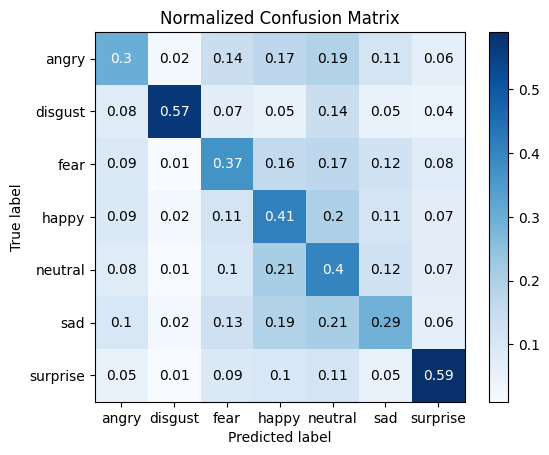

In [ ]:
y_test_pred = knn_cos.predict(X_test.reshape(X_test.shape[0], -1))

skplt.metrics.plot_confusion_matrix(lb_encoder.inverse_transform(y_test), lb_encoder.inverse_transform(y_test_pred), normalize=True)
print(classification_report(lb_encoder.inverse_transform(y_test), lb_encoder.inverse_transform(y_test_pred)))

knn_img['cosine'] = f1_score(y_test, y_test_pred, average='micro')

In [ ]:
knn_models['image'] = knn_img

## HOG

### Euclidean

In [ ]:
knn_hog = dict()

In [ ]:
knn_hog_euc = pickle.load(open('/content/drive/MyDrive/PYTHON/CV/DoAn/checkpoint/model/knn_hog_euc.pkl', 'rb'))

score_per_K_hog = pickle.load(open('/content/drive/MyDrive/PYTHON/CV/DoAn/checkpoint/loss/knn_hog_euc.pkl', 'rb'))

(0.0, 1.0)

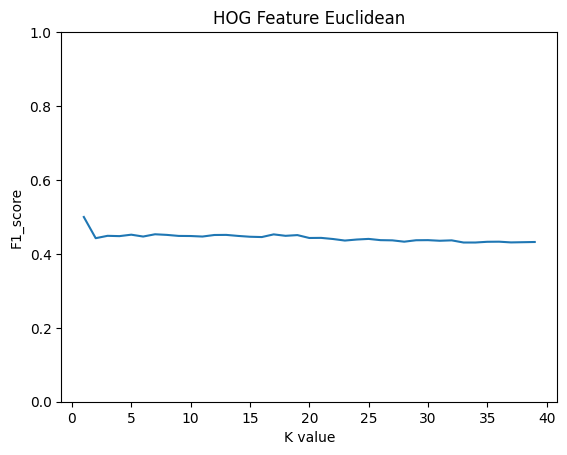

In [ ]:
plt.plot(range(1, len(score_per_K_hog)+1), score_per_K_hog)
plt.xlabel('K value')
plt.ylabel('F1_score')
plt.title('HOG Feature Euclidean')
plt.ylim(0, 1)

              precision    recall  f1-score   support

       angry       0.42      0.38      0.40       958
     disgust       0.50      0.59      0.54       111
        fear       0.47      0.41      0.44      1024
       happy       0.58      0.66      0.62      1774
     neutral       0.41      0.45      0.43      1233
         sad       0.43      0.36      0.39      1247
    surprise       0.61      0.65      0.63       831

    accuracy                           0.50      7178
   macro avg       0.49      0.50      0.49      7178
weighted avg       0.49      0.50      0.49      7178



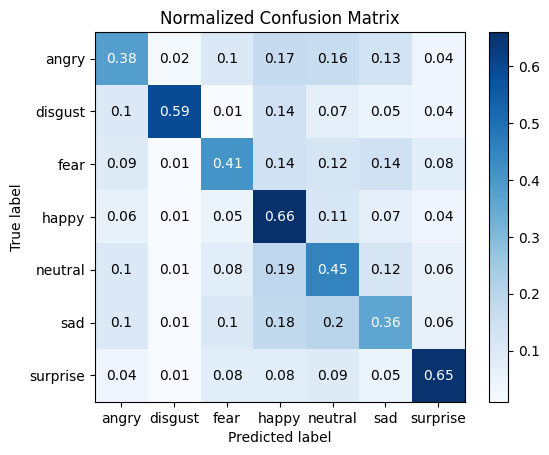

In [ ]:
y_test_pred = knn_hog_euc.predict(X_test_hog)

skplt.metrics.plot_confusion_matrix(lb_encoder.inverse_transform(y_test_hog), lb_encoder.inverse_transform(y_test_pred), normalize=True)
print(classification_report(lb_encoder.inverse_transform(y_test_hog), lb_encoder.inverse_transform(y_test_pred)))

knn_hog['euclidean'] = f1_score(y_test_hog, y_test_pred, average='micro')

### Cosine

In [ ]:
knn_hog_cos = pickle.load(open('/content/drive/MyDrive/PYTHON/CV/DoAn/checkpoint/model/knn_hog_cos.pkl', 'rb'))

score_per_K_hog = pickle.load(open('/content/drive/MyDrive/PYTHON/CV/DoAn/checkpoint/loss/knn_hog_cos.pkl', 'rb'))

(0.0, 1.0)

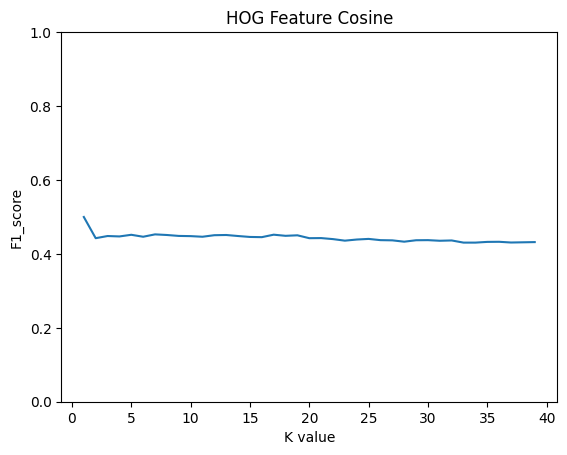

In [ ]:
plt.plot(range(1, len(score_per_K_hog)+1), score_per_K_hog)
plt.xlabel('K value')
plt.ylabel('F1_score')
plt.title('HOG Feature Cosine')
plt.ylim(0, 1)

              precision    recall  f1-score   support

       angry       0.42      0.38      0.40       958
     disgust       0.50      0.59      0.54       111
        fear       0.47      0.41      0.44      1024
       happy       0.58      0.66      0.62      1774
     neutral       0.41      0.45      0.43      1233
         sad       0.43      0.36      0.39      1247
    surprise       0.61      0.65      0.63       831

    accuracy                           0.50      7178
   macro avg       0.49      0.50      0.49      7178
weighted avg       0.49      0.50      0.49      7178



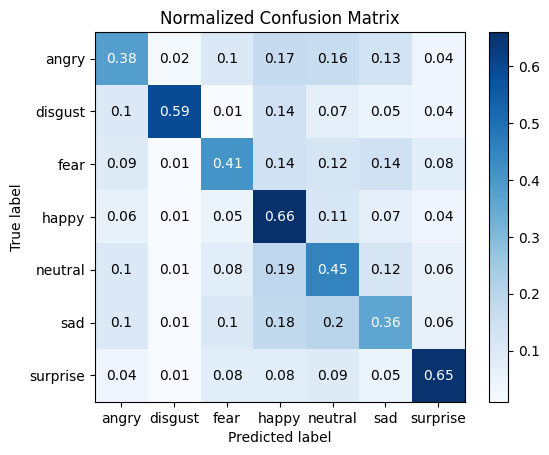

In [ ]:
y_test_pred = knn_hog_cos.predict(X_test_hog)

skplt.metrics.plot_confusion_matrix(lb_encoder.inverse_transform(y_test_hog), lb_encoder.inverse_transform(y_test_pred), normalize=True)
print(classification_report(lb_encoder.inverse_transform(y_test_hog), lb_encoder.inverse_transform(y_test_pred)))

knn_hog['cosine'] = f1_score(y_test_hog, y_test_pred, average='micro')

In [ ]:
knn_models['Hog'] = knn_hog

## Keypoint

### Euclidean

In [ ]:
knn_kp = dict()

In [ ]:
knn_kp_euc = pickle.load(open('/content/drive/MyDrive/PYTHON/CV/DoAn/checkpoint/model/knn_kp_euc.pkl', 'rb'))

score_per_K_kp = pickle.load(open('/content/drive/MyDrive/PYTHON/CV/DoAn/checkpoint/loss/knn_kp_euc.pkl', 'rb'))

(0.0, 1.0)

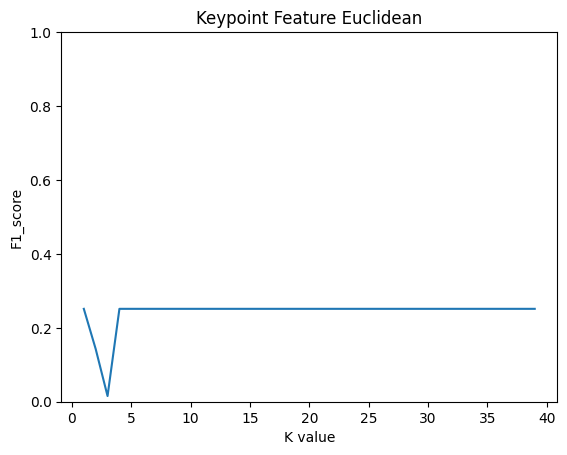

In [ ]:
plt.plot(range(1, len(score_per_K_kp)+1), score_per_K_kp)
plt.xlabel('K value')
plt.ylabel('F1_score')
plt.title('Keypoint Feature Euclidean')
plt.ylim(0, 1)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       angry       0.00      0.00      0.00       958
     disgust       0.00      0.00      0.00       111
        fear       0.14      1.00      0.25      1024
       happy       0.00      0.00      0.00      1774
     neutral       0.00      0.00      0.00      1233
         sad       0.00      0.00      0.00      1247
    surprise       0.00      0.00      0.00       831

    accuracy                           0.14      7178
   macro avg       0.02      0.14      0.04      7178
weighted avg       0.02      0.14      0.04      7178



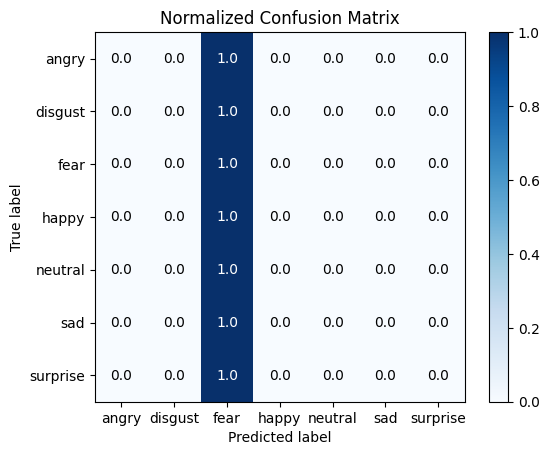

In [ ]:
y_test_pred = knn_kp_euc.predict(X_test_kp.reshape(X_test_kp.shape[0], -1))

skplt.metrics.plot_confusion_matrix(lb_encoder.inverse_transform(y_test_kp), lb_encoder.inverse_transform(y_test_pred), normalize=True)
print(classification_report(lb_encoder.inverse_transform(y_test_kp), lb_encoder.inverse_transform(y_test_pred)))

knn_kp['euclidean'] = f1_score(y_test_kp, y_test_pred, average='micro')

### Cosine

In [ ]:
knn_kp_cos = pickle.load(open('/content/drive/MyDrive/PYTHON/CV/DoAn/checkpoint/model/knn_kp_cos.pkl', 'rb'))

score_per_K_kp = pickle.load(open('/content/drive/MyDrive/PYTHON/CV/DoAn/checkpoint/loss/knn_kp_cos.pkl', 'rb'))

(0.0, 1.0)

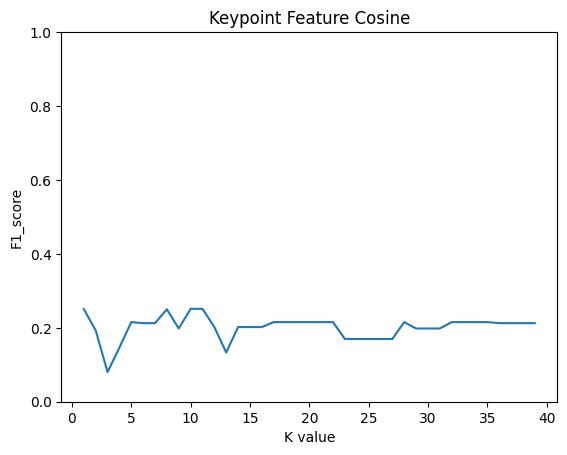

In [ ]:
plt.plot(range(1, len(score_per_K_kp)+1), score_per_K_kp)
plt.xlabel('K value')
plt.ylabel('F1_score')
plt.title('Keypoint Feature Cosine')
plt.ylim(0, 1)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       angry       0.00      0.00      0.00       958
     disgust       0.00      0.00      0.00       111
        fear       0.00      0.00      0.00      1024
       happy       0.15      0.00      0.00      1774
     neutral       0.17      0.50      0.26      1233
         sad       0.17      0.50      0.26      1247
    surprise       0.00      0.00      0.00       831

    accuracy                           0.17      7178
   macro avg       0.07      0.14      0.07      7178
weighted avg       0.10      0.17      0.09      7178



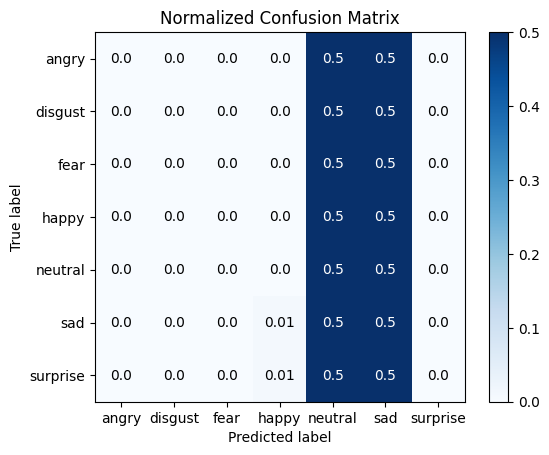

In [ ]:
y_test_pred = knn_kp_cos.predict(X_test_kp.reshape(X_test_kp.shape[0], -1))

skplt.metrics.plot_confusion_matrix(lb_encoder.inverse_transform(y_test_kp), lb_encoder.inverse_transform(y_test_pred), normalize=True)
print(classification_report(lb_encoder.inverse_transform(y_test_kp), lb_encoder.inverse_transform(y_test_pred)))

knn_kp['cosine'] = f1_score(y_test_kp, y_test_pred, average='micro')

In [ ]:
knn_models['kp'] = knn_kp

In [ ]:
acc_models['knn'] = knn_models

# SVM

## Image

In [ ]:
svm_models = dict()

In [ ]:
svm = pickle.load(open('/content/drive/MyDrive/PYTHON/CV/DoAn/checkpoint/model/svm_image.pkl', 'rb'))

              precision    recall  f1-score   support

       angry       0.24      0.11      0.15       958
     disgust       0.27      0.15      0.19       111
        fear       0.28      0.08      0.12      1024
       happy       0.42      0.61      0.49      1774
     neutral       0.28      0.32      0.30      1233
         sad       0.28      0.31      0.29      1247
    surprise       0.41      0.50      0.45       831

    accuracy                           0.34      7178
   macro avg       0.31      0.30      0.29      7178
weighted avg       0.32      0.34      0.32      7178



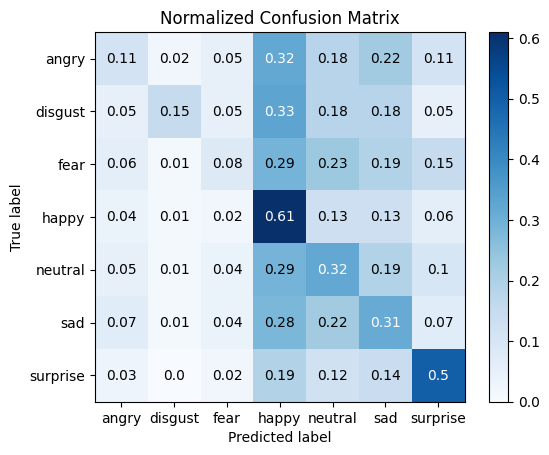

In [ ]:
y_test_pred = svm.predict(X_test.reshape(X_test.shape[0], -1))

skplt.metrics.plot_confusion_matrix(lb_encoder.inverse_transform(y_test), lb_encoder.inverse_transform(y_test_pred), normalize=True)
print(classification_report(lb_encoder.inverse_transform(y_test), lb_encoder.inverse_transform(y_test_pred)))

svm_models['image_feature'] = f1_score(y_test, y_test_pred, average='micro')

## HOG

In [ ]:
svm_hog = pickle.load(open('/content/drive/MyDrive/PYTHON/CV/DoAn/checkpoint/model/svm_hog.pkl', 'rb'))

              precision    recall  f1-score   support

       angry       0.33      0.25      0.28       958
     disgust       0.45      0.18      0.26       111
        fear       0.32      0.18      0.23      1024
       happy       0.53      0.77      0.63      1774
     neutral       0.40      0.44      0.42      1233
         sad       0.31      0.25      0.28      1247
    surprise       0.53      0.56      0.54       831

    accuracy                           0.44      7178
   macro avg       0.41      0.38      0.38      7178
weighted avg       0.41      0.44      0.41      7178



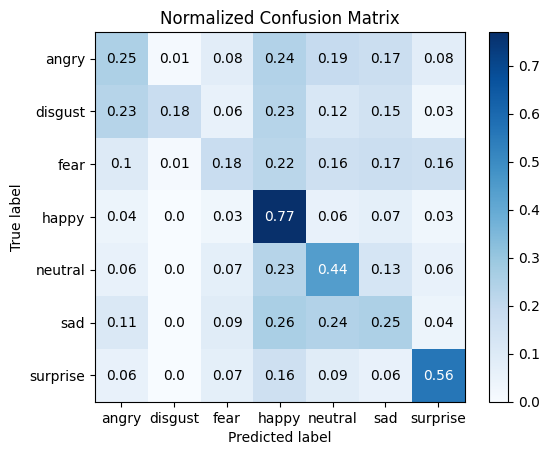

In [ ]:
y_test_pred = svm_hog.predict(X_test_hog)

skplt.metrics.plot_confusion_matrix(lb_encoder.inverse_transform(y_test_hog), lb_encoder.inverse_transform(y_test_pred), normalize=True)
print(classification_report(lb_encoder.inverse_transform(y_test_hog), lb_encoder.inverse_transform(y_test_pred)))

svm_models['HOG_feature'] = f1_score(y_test_hog, y_test_pred, average='micro')

## Keypoint

In [ ]:
svm_kp = pickle.load(open('/content/drive/MyDrive/PYTHON/CV/DoAn/checkpoint/model/svm_kp.pkl', 'rb'))

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       angry       0.00      0.00      0.00       958
     disgust       0.00      0.00      0.00       111
        fear       0.00      0.00      0.00      1024
       happy       0.00      0.00      0.00      1774
     neutral       0.17      1.00      0.29      1233
         sad       0.00      0.00      0.00      1247
    surprise       0.00      0.00      0.00       831

    accuracy                           0.17      7178
   macro avg       0.02      0.14      0.04      7178
weighted avg       0.03      0.17      0.05      7178



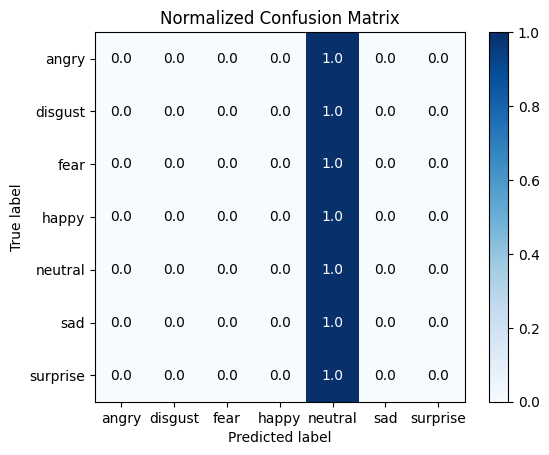

In [ ]:
y_test_pred = svm_kp.predict(X_test_kp.reshape(X_test.shape[0], -1))

skplt.metrics.plot_confusion_matrix(lb_encoder.inverse_transform(y_test_kp), lb_encoder.inverse_transform(y_test_pred), normalize=True)
print(classification_report(lb_encoder.inverse_transform(y_test_kp), lb_encoder.inverse_transform(y_test_pred)))

svm_models['Keypoint_feature'] = f1_score(y_test_kp, y_test_pred, average='micro')

In [ ]:
acc_models['svm'] = svm_models

# MLP

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, n_hidden_node):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, n_hidden_node),
            nn.ReLU(),
            nn.Linear(n_hidden_node, output_dim)
        )

    def forward(self, x):
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs

In [ ]:
def predict(data_loader, model):
  label_pred = []
  model.eval()

  with torch.no_grad():
    for (imgs, labels) in data_loader:
      imgs, labels = imgs.to(device), labels.to(device)
      imgs = imgs.reshape(imgs.shape[0], -1)

      #forward
      _, probs = model(imgs)
      _, y_pred = probs.max(1)

      for i in range(len(y_pred)):
        label_pred.append(y_pred[i].item())

  return label_pred

In [ ]:
mlp_models = dict()

## Mean

### Image

In [ ]:
mlp_mean_models = dict()

In [ ]:
mlp_mean = MLP(48*48, 7, math.floor((48*48+7)/2)).to(device)
mlp_mean

MLP(
  (classifier): Sequential(
    (0): Linear(in_features=2304, out_features=1155, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1155, out_features=7, bias=True)
  )
)

In [ ]:
checkpoint = torch.load('/content/drive/MyDrive/PYTHON/CV/DoAn/checkpoint/model/mlp_mean.pt')

mlp_mean.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

              precision    recall  f1-score   support

       angry       0.30      0.23      0.26       958
     disgust       1.00      0.05      0.10       111
        fear       0.28      0.13      0.18      1024
       happy       0.46      0.72      0.56      1774
     neutral       0.35      0.39      0.37      1233
         sad       0.34      0.31      0.33      1247
    surprise       0.59      0.48      0.53       831

    accuracy                           0.41      7178
   macro avg       0.48      0.33      0.33      7178
weighted avg       0.40      0.41      0.38      7178



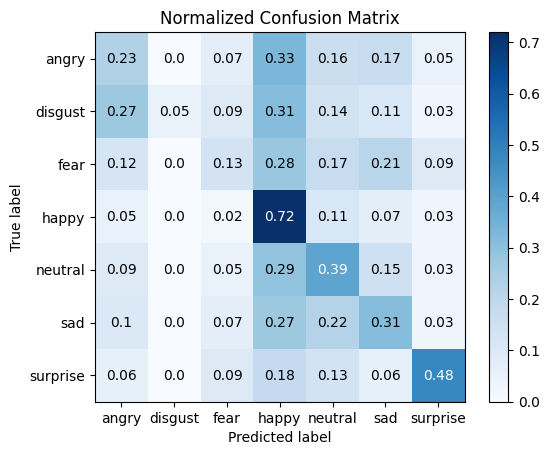

In [ ]:
y_test_pred = predict(test_loader, mlp_mean)

skplt.metrics.plot_confusion_matrix(lb_encoder.inverse_transform(y_test), lb_encoder.inverse_transform(y_test_pred), normalize=True)
print(classification_report(lb_encoder.inverse_transform(y_test), lb_encoder.inverse_transform(y_test_pred)))

mlp_mean_models['image_feature'] = f1_score(y_test, y_test_pred, average='micro')

### HOG

In [ ]:
mlp_mean_hog = MLP(900, 7, math.floor((900+7)/2)).to(device)
mlp_mean_hog

MLP(
  (classifier): Sequential(
    (0): Linear(in_features=900, out_features=453, bias=True)
    (1): ReLU()
    (2): Linear(in_features=453, out_features=7, bias=True)
  )
)

In [ ]:
checkpoint = torch.load('/content/drive/MyDrive/PYTHON/CV/DoAn/checkpoint/model/mlp_mean_hog.pt')

mlp_mean_hog.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

              precision    recall  f1-score   support

       angry       0.40      0.35      0.37       958
     disgust       0.44      0.42      0.43       111
        fear       0.35      0.34      0.34      1024
       happy       0.57      0.84      0.68      1774
     neutral       0.53      0.35      0.42      1233
         sad       0.40      0.35      0.37      1247
    surprise       0.71      0.60      0.65       831

    accuracy                           0.50      7178
   macro avg       0.49      0.46      0.47      7178
weighted avg       0.49      0.50      0.49      7178



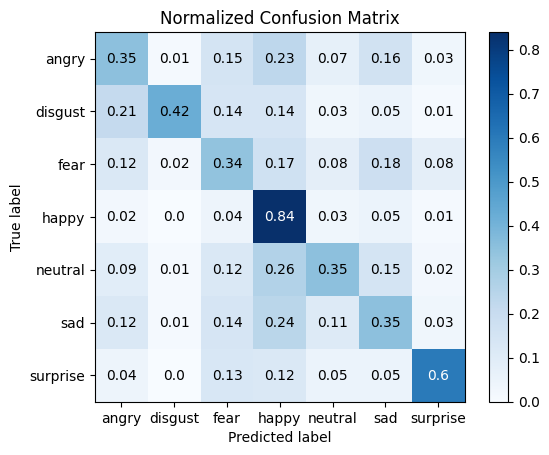

In [ ]:
y_test_pred = predict(test_hog_loader, mlp_mean_hog)

skplt.metrics.plot_confusion_matrix(lb_encoder.inverse_transform(y_test_hog), lb_encoder.inverse_transform(y_test_pred), normalize=True)
print(classification_report(lb_encoder.inverse_transform(y_test_hog), lb_encoder.inverse_transform(y_test_pred)))

mlp_mean_models['HOG_feature'] = f1_score(y_test_hog, y_test_pred, average='micro')

### Keypoint

In [ ]:
mlp_mean_kp = MLP(48*48, 7, math.floor((48*48+7)/2)).to(device)
mlp_mean_kp

MLP(
  (classifier): Sequential(
    (0): Linear(in_features=2304, out_features=1155, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1155, out_features=7, bias=True)
  )
)

In [ ]:
checkpoint = torch.load('/content/drive/MyDrive/PYTHON/CV/DoAn/checkpoint/model/mlp_mean_kp.pt')

mlp_mean_kp.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       angry       0.00      0.00      0.00       958
     disgust       0.00      0.00      0.00       111
        fear       0.00      0.00      0.00      1024
       happy       0.25      1.00      0.40      1774
     neutral       0.00      0.00      0.00      1233
         sad       0.00      0.00      0.00      1247
    surprise       0.00      0.00      0.00       831

    accuracy                           0.25      7178
   macro avg       0.04      0.14      0.06      7178
weighted avg       0.06      0.25      0.10      7178



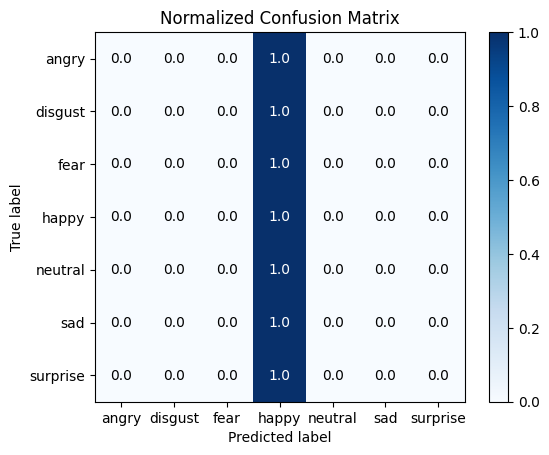

In [ ]:
y_test_pred = predict(test_kp_loader, mlp_mean_kp)

skplt.metrics.plot_confusion_matrix(lb_encoder.inverse_transform(y_test_kp), lb_encoder.inverse_transform(y_test_pred), normalize=True)
print(classification_report(lb_encoder.inverse_transform(y_test_kp), lb_encoder.inverse_transform(y_test_pred)))

mlp_mean_models['Keypoint_feature'] = f1_score(y_test_kp, y_test_pred, average='micro')

In [ ]:
mlp_models['mean'] = mlp_mean_models

## Geometric

### Image

In [ ]:
mlp_geo_models = dict()

In [ ]:
mlp_geo = MLP(48*48, 7, math.floor(math.sqrt(48*48*7))).to(device)
mlp_geo

MLP(
  (classifier): Sequential(
    (0): Linear(in_features=2304, out_features=126, bias=True)
    (1): ReLU()
    (2): Linear(in_features=126, out_features=7, bias=True)
  )
)

In [ ]:
checkpoint = torch.load('/content/drive/MyDrive/PYTHON/CV/DoAn/checkpoint/model/mlp_geo.pt')

mlp_geo.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       angry       0.27      0.20      0.23       958
     disgust       0.00      0.00      0.00       111
        fear       0.27      0.10      0.15      1024
       happy       0.46      0.70      0.56      1774
     neutral       0.34      0.37      0.35      1233
         sad       0.30      0.32      0.31      1247
    surprise       0.57      0.49      0.53       831

    accuracy                           0.39      7178
   macro avg       0.32      0.31      0.30      7178
weighted avg       0.36      0.39      0.36      7178



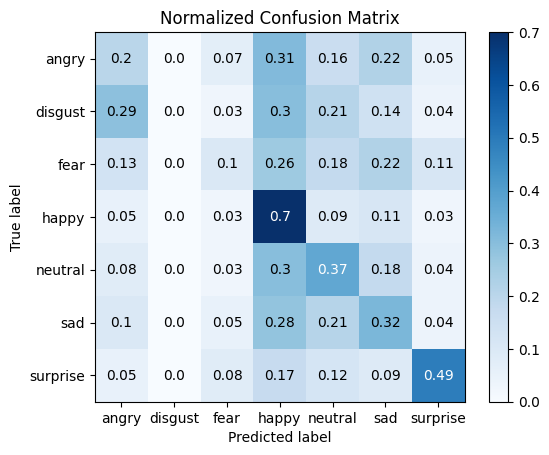

In [ ]:
y_test_pred = predict(test_loader, mlp_geo)

skplt.metrics.plot_confusion_matrix(lb_encoder.inverse_transform(y_test), lb_encoder.inverse_transform(y_test_pred), normalize=True)
print(classification_report(lb_encoder.inverse_transform(y_test), lb_encoder.inverse_transform(y_test_pred)))

mlp_geo_models['image_feature'] = f1_score(y_test, y_test_pred, average='micro')

### HOG

In [ ]:
mlp_geo_hog = MLP(900, 7, math.floor(math.sqrt(900*7))).to(device)
mlp_geo_hog

MLP(
  (classifier): Sequential(
    (0): Linear(in_features=900, out_features=79, bias=True)
    (1): ReLU()
    (2): Linear(in_features=79, out_features=7, bias=True)
  )
)

In [ ]:
checkpoint = torch.load('/content/drive/MyDrive/PYTHON/CV/DoAn/checkpoint/model/mlp_geo_hog.pt')

mlp_geo_hog.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

              precision    recall  f1-score   support

       angry       0.31      0.35      0.33       958
     disgust       0.28      0.38      0.32       111
        fear       0.32      0.33      0.33      1024
       happy       0.67      0.64      0.65      1774
     neutral       0.42      0.38      0.40      1233
         sad       0.32      0.36      0.34      1247
    surprise       0.64      0.50      0.56       831

    accuracy                           0.44      7178
   macro avg       0.42      0.42      0.42      7178
weighted avg       0.46      0.44      0.45      7178



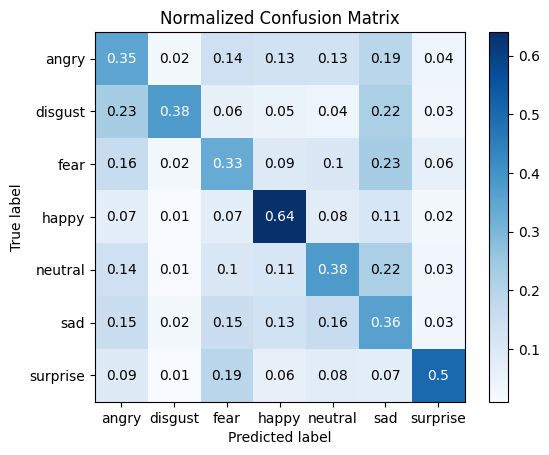

In [ ]:
y_test_pred = predict(test_hog_loader, mlp_geo_hog)

skplt.metrics.plot_confusion_matrix(lb_encoder.inverse_transform(y_test_hog), lb_encoder.inverse_transform(y_test_pred), normalize=True)
print(classification_report(lb_encoder.inverse_transform(y_test_hog), lb_encoder.inverse_transform(y_test_pred)))

mlp_geo_models['HOG_feature'] = f1_score(y_test_hog, y_test_pred, average='micro')

### Keypoint

In [ ]:
mlp_geo_kp = MLP(48*48, 7, math.floor(math.sqrt(48*48*7))).to(device)
mlp_geo_kp

MLP(
  (classifier): Sequential(
    (0): Linear(in_features=2304, out_features=126, bias=True)
    (1): ReLU()
    (2): Linear(in_features=126, out_features=7, bias=True)
  )
)

In [ ]:
checkpoint = torch.load('/content/drive/MyDrive/PYTHON/CV/DoAn/checkpoint/model/mlp_geo_kp.pt')

mlp_geo_kp.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       angry       0.00      0.00      0.00       958
     disgust       0.00      0.00      0.00       111
        fear       0.00      0.00      0.00      1024
       happy       0.25      1.00      0.40      1774
     neutral       0.00      0.00      0.00      1233
         sad       0.00      0.00      0.00      1247
    surprise       0.00      0.00      0.00       831

    accuracy                           0.25      7178
   macro avg       0.04      0.14      0.06      7178
weighted avg       0.06      0.25      0.10      7178



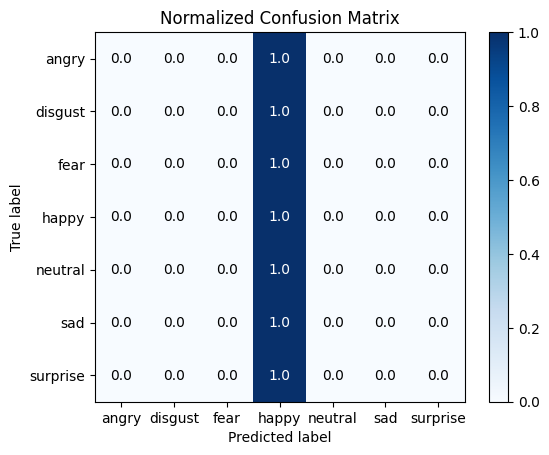

In [ ]:
y_test_pred = predict(test_kp_loader, mlp_geo_kp)

skplt.metrics.plot_confusion_matrix(lb_encoder.inverse_transform(y_test_kp), lb_encoder.inverse_transform(y_test_pred), normalize=True)
print(classification_report(lb_encoder.inverse_transform(y_test_kp), lb_encoder.inverse_transform(y_test_pred)))

mlp_geo_models['Keypoint_feature'] = f1_score(y_test_kp, y_test_pred, average='micro')

In [ ]:
mlp_models['geo'] = mlp_geo_models

## Jeff

### Image

In [ ]:
mlp_jeff_models = dict()

In [ ]:
mlp_jeff = MLP(48*48, 7, math.floor(2/3*48*48 + 7)).to(device)
mlp_jeff

MLP(
  (classifier): Sequential(
    (0): Linear(in_features=2304, out_features=1543, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1543, out_features=7, bias=True)
  )
)

In [ ]:
checkpoint = torch.load('/content/drive/MyDrive/PYTHON/CV/DoAn/checkpoint/model/mlp_jeff.pt')

mlp_jeff.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

              precision    recall  f1-score   support

       angry       0.32      0.21      0.25       958
     disgust       0.39      0.20      0.26       111
        fear       0.27      0.32      0.29      1024
       happy       0.53      0.61      0.57      1774
     neutral       0.37      0.33      0.35      1233
         sad       0.29      0.32      0.31      1247
    surprise       0.57      0.51      0.54       831

    accuracy                           0.40      7178
   macro avg       0.39      0.36      0.37      7178
weighted avg       0.40      0.40      0.40      7178



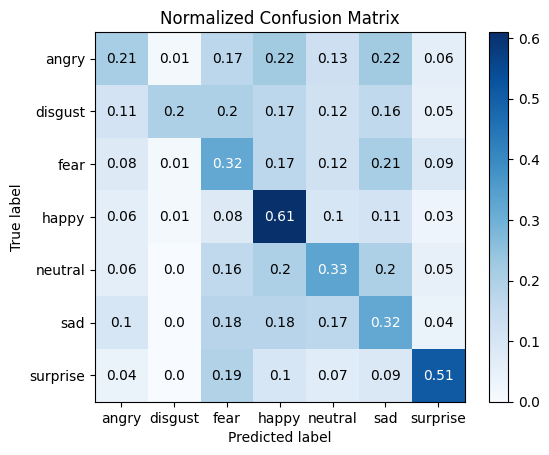

In [ ]:
y_test_pred = predict(test_loader, mlp_jeff)

skplt.metrics.plot_confusion_matrix(lb_encoder.inverse_transform(y_test), lb_encoder.inverse_transform(y_test_pred), normalize=True)
print(classification_report(lb_encoder.inverse_transform(y_test), lb_encoder.inverse_transform(y_test_pred)))

mlp_jeff_models['Image_feature'] = f1_score(y_test, y_test_pred, average='micro')

### HOG

In [ ]:
mlp_jeff_hog = MLP(900, 7, math.floor(2/3*900 + 7)).to(device)
mlp_jeff_hog

MLP(
  (classifier): Sequential(
    (0): Linear(in_features=900, out_features=607, bias=True)
    (1): ReLU()
    (2): Linear(in_features=607, out_features=7, bias=True)
  )
)

In [ ]:
checkpoint = torch.load('/content/drive/MyDrive/PYTHON/CV/DoAn/checkpoint/model/mlp_jeff_hog.pt')

mlp_jeff_hog.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

              precision    recall  f1-score   support

       angry       0.37      0.46      0.41       958
     disgust       0.60      0.29      0.39       111
        fear       0.47      0.21      0.29      1024
       happy       0.61      0.78      0.68      1774
     neutral       0.48      0.47      0.47      1233
         sad       0.41      0.35      0.38      1247
    surprise       0.62      0.69      0.65       831

    accuracy                           0.51      7178
   macro avg       0.51      0.46      0.47      7178
weighted avg       0.50      0.51      0.49      7178



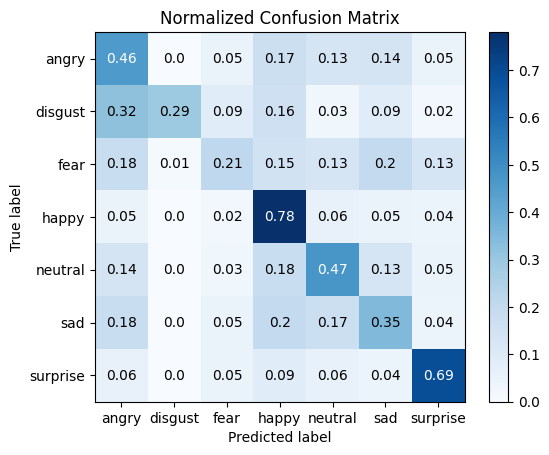

In [ ]:
y_test_pred = predict(test_hog_loader, mlp_jeff_hog)

skplt.metrics.plot_confusion_matrix(lb_encoder.inverse_transform(y_test_hog), lb_encoder.inverse_transform(y_test_pred), normalize=True)
print(classification_report(lb_encoder.inverse_transform(y_test_hog), lb_encoder.inverse_transform(y_test_pred)))

mlp_jeff_models['HOG_feature'] = f1_score(y_test_hog, y_test_pred, average='micro')

### Keypoint

In [ ]:
mlp_jeff_kp = MLP(48*48, 7, math.floor(2/3*48*48 + 7)).to(device)
mlp_jeff_kp

MLP(
  (classifier): Sequential(
    (0): Linear(in_features=2304, out_features=1543, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1543, out_features=7, bias=True)
  )
)

In [ ]:
checkpoint = torch.load('/content/drive/MyDrive/PYTHON/CV/DoAn/checkpoint/model/mlp_jeff_kp.pt')

mlp_jeff_kp.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       angry       0.00      0.00      0.00       958
     disgust       0.00      0.00      0.00       111
        fear       0.00      0.00      0.00      1024
       happy       0.25      1.00      0.40      1774
     neutral       0.00      0.00      0.00      1233
         sad       0.00      0.00      0.00      1247
    surprise       0.00      0.00      0.00       831

    accuracy                           0.25      7178
   macro avg       0.04      0.14      0.06      7178
weighted avg       0.06      0.25      0.10      7178



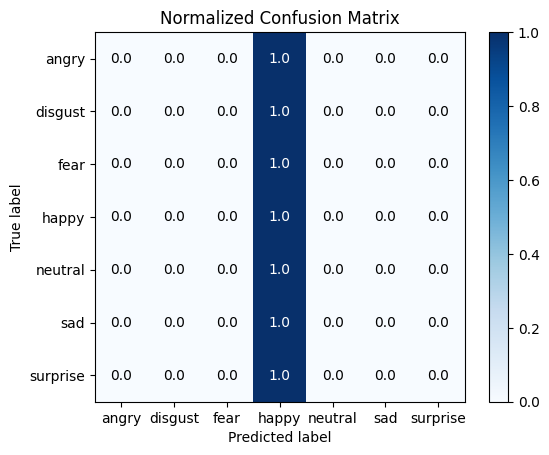

In [ ]:
y_test_pred = predict(test_kp_loader, mlp_jeff_kp)

skplt.metrics.plot_confusion_matrix(lb_encoder.inverse_transform(y_test_kp), lb_encoder.inverse_transform(y_test_pred), normalize=True)
print(classification_report(lb_encoder.inverse_transform(y_test_kp), lb_encoder.inverse_transform(y_test_pred)))

mlp_jeff_models['Keypoint_feature'] = f1_score(y_test_kp, y_test_pred, average='micro')

In [ ]:
mlp_models['jeff'] = mlp_jeff_models

In [ ]:
acc_models['mlp'] = mlp_models

# Conclude

In [ ]:
acc_models

{'knn': {'image': {'euclidean': 0.3889662858735023,
   'cosine': 0.3886876567288938},
  'Hog': {'euclidean': 0.4959598774031764, 'cosine': 0.4959598774031764},
  'kp': {'euclidean': 0.14265812203956535, 'cosine': 0.1728893842295904}},
 'svm': {'image_feature': 0.34466425188074673,
  'HOG_feature': 0.4360546113123433,
  'Keypoint_feature': 0.17177486765115632},
 'mlp': {'mean': {'image_feature': 0.40596266369462247,
   'HOG_feature': 0.49986068542769574,
   'Keypoint_feature': 0.24714405126776262},
  'geo': {'image_feature': 0.38980217330732797,
   'HOG_feature': 0.4446921147952076,
   'Keypoint_feature': 0.24714405126776262},
  'jeff': {'Image_feature': 0.39955419336862635,
   'HOG_feature': 0.5103092783505154,
   'Keypoint_feature': 0.24714405126776262}}}

| Model Type     | Model | Feature  | Setting        | Layer           | Accuracy |
| -------------- | ----- | -------- | -------------- | --------------- | -------- |
| Lazy           | KNN   | Image    | Euclidean      |                 | 38.89%   |
|                |       |          | Cosine         |                 | 38.86%   |
|                |       | HOG      | Euclidean      |                 | 49.59%   |
|                |       |          | Cosine         |                 | 49.59%   |
|                |       | Keypoint | Euclidean      |                 | 14.26%   |
|                |       |          | Cosine         |                 | 17.29%   |
| Linear         | SVM   | Image    | Linear SVC     |                 | 34.47%   |
|                |       | HOG      |                |                 | 43.60%   |
|                |       | Keypoint |                |                 | 17.18%   |
| Neural Network | MLP   | Image    | Airhmetic Mean | (2304, 1155, 7) | 39.24%   |
|                |       | HOG      |                | (900, 453, 7)   | 49.99%   |
|                |       | Keypoint |                | (2304, 1155, 7) | 24.71%   |
|                |       | Image    | Geometric Mean | (2304, 126, 7)  | 38.98%   |
|                |       | HOG      |                | (900, 79, 7)    | 44.47%   |
|                |       | Keypoint |                | (2304, 126, 7)  | 24.71%   |
|                |       | Image    | Jeff Heaton's  | (2304, 1543, 7) | 39.96%   |
|                |       | HOG      |                | (900, 607, 7)   | 51.03%   |
|                |       | Keypoint |                | (2304, 1543, 7) | 24.71%   |


# Demo

In [ ]:
def predict_one(input, model, d_type, d_model):
  if d_model == 'knn' or d_model == 'svm':
    return model.predict(input.reshape(1, -1))
  elif d_model == 'mlp':
    model.eval()
    with torch.no_grad():
      if d_type == 'image':
        input = torch.tensor(input/255, dtype=torch.float)
      elif d_type == 'HOG':
        input = torch.tensor(input, dtype=torch.float)
      elif d_type == 'kp':
        input = torch.tensor(input, dtype=torch.float)
      else:
        print("Not recognize d_type '{d_type}'")
        return
      _, probs = model(torch.reshape(input, (1, -1)))
      _, pred = probs.max(1)

      return [pred.item()]
  else:
    print(f"Not recognize d_model '{d_model}'")
    return

In [ ]:
def readUrl(img_url, type):
  url_response = urllib.request.urlopen(img_url)
  img_array = np.array(bytearray(url_response.read()), dtype=np.uint8)

  img = cv2.imdecode(img_array, type)
  return img

In [ ]:
def rect_to_bb(rect):
  x = rect.left()
  y = rect.top()
  w = rect.right() - x
  h = rect.bottom() - y
  return (x, y, w, h)

In [ ]:
def crop_img(img, x, y, w, h):
  crop_img = img[y:y+h, x:x+w]
  return crop_img

In [ ]:
def detect_face(img_dir_or_img_url, d_type):
  face_img = []

  frontalface_detector = dlib.get_frontal_face_detector()
  if d_type == 'dir':
    img = cv2.imread(img_dir_or_img_url, 0)
  elif d_type == 'url':
    img = readUrl(img_dir_or_img_url, 0)
  else:
    print(f"Not recognize d_type '{d_type}'")
    return face_img

  rects = frontalface_detector(img, 1)
  if len(rects) < 1:
    print('No Face Detected')
  else:
    for(i, rect) in enumerate(rects):
      (x, y, w, h) = rect_to_bb(rect)
      face_img.append(crop_img(img, x, y, w, h))
  return face_img

In [ ]:
def harris(img, threshold):


  mask = np.float32(gray)
  mask_img = np.float32(gray)

  corners = cv2.cornerHarris(img, 2, 3, 0.05)
  corners = cv2.dilate(corners, None)

  mask_img[True] = 255
  mask_img[corners > threshold * corners.max()]= 0

  mask[True] = 1
  mask[corners > threshold * corners.max()]= 0

  return mask, mask_img

In [ ]:
def pred_emotion(lb_encoder, img_dir_or_img_url, model, d_model, d_feature, d_type, threshold=0.04):
  face_img = detect_face(img_dir_or_img_url, d_type)

  if len(face_img) == 0:
    return
  for img in face_img:
    if img.shape[0] == 0 or img.shape[1] == 0:
      continue
    img_resize = cv2.resize(img, (48, 48))

    if d_feature == 'image':

      fig, ax = plt.subplots(1, 2)
      ax[0].imshow(img, cmap='gray')
      ax[1].imshow(img_resize, cmap='gray')

      print(f"Emotion:{lb_encoder.inverse_transform(predict_one(img_resize, model, d_feature, d_model))[0]}")
    elif d_feature == 'HOG':
      hog, hog_img = feature.hog(img_resize, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), block_norm='L2-Hys', visualize=True, transform_sqrt=True)

      fig, ax = plt.subplots(1, 2)
      ax[0].imshow(img, cmap='gray')
      ax[1].imshow(hog_img, cmap='gray')

      print(f"Emotion:{lb_encoder.inverse_transform(predict_one(hog, model, d_feature, d_model))[0]}")
    elif d_feature == 'kp':
      mask, mask_img = harris(img_resize, threshold)

      fig, ax = plt.subplots(1, 2)
      ax[0].imshow(img, cmap='gray')
      ax[1].imshow(mask_img, cmap='gray')

      print(f"Emotion:{lb_encoder.inverse_transform(predict_one(mask, model, d_feature, d_model))[0]}")
    else:
      print(f"Not regconize d_feature '{d_feature}'")
      return

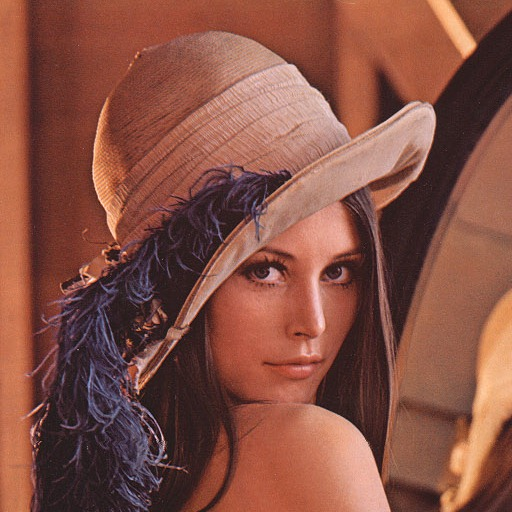

Emotion:happy


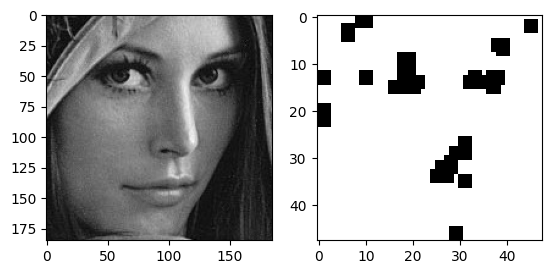

In [ ]:
img_dir = '/content/drive/MyDrive/PYTHON/CV/Baitap01/images/lena.jpg'

cv2_imshow(cv2.imread(img_dir, 1))
pred_emotion(lb_encoder, img_dir, mlp_jeff_kp, 'mlp', 'kp', 'dir', 0.02)

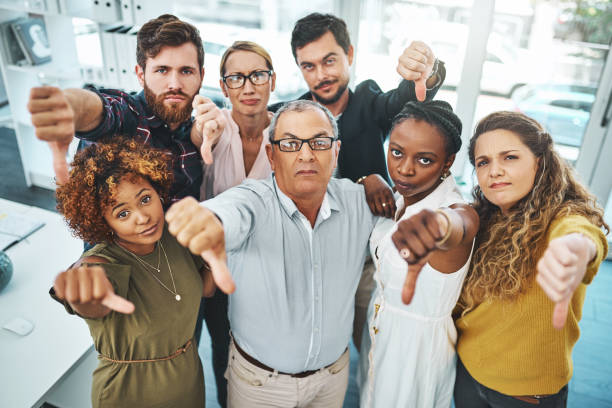

Emotion:happy
Emotion:neutral
Emotion:neutral
Emotion:happy
Emotion:angry
Emotion:happy
Emotion:sad


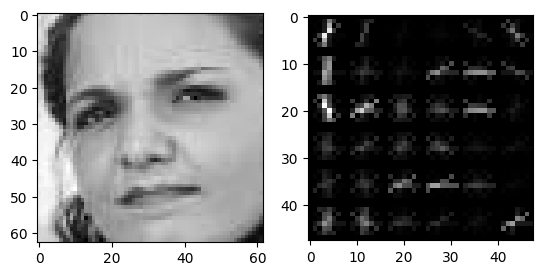

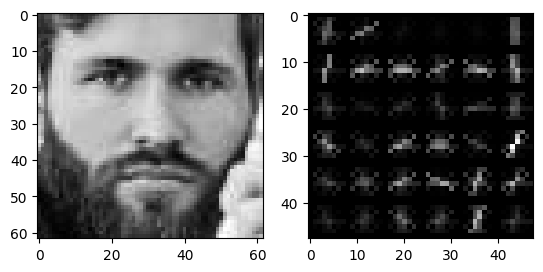

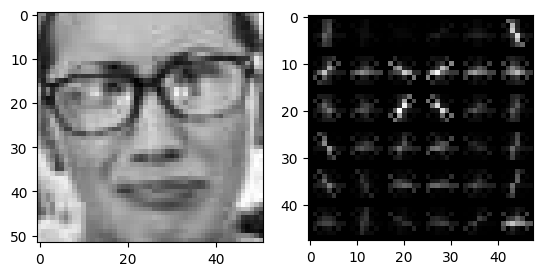

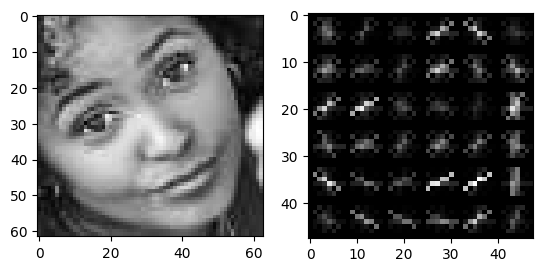

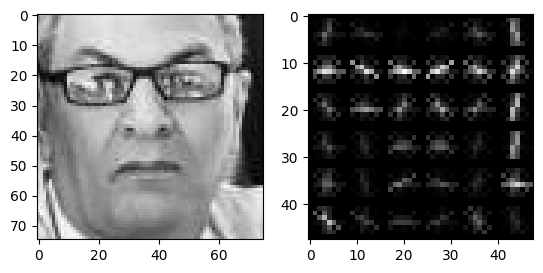

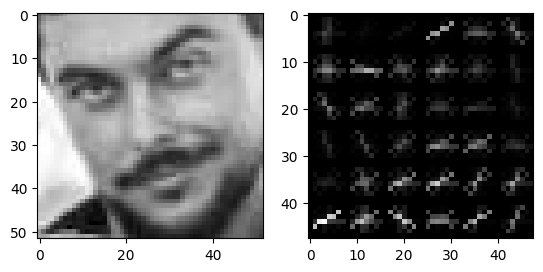

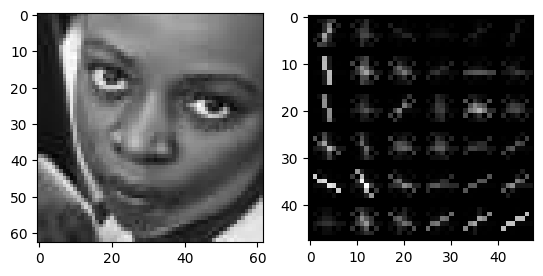

In [ ]:
img_url = 'https://media.istockphoto.com/id/1141421597/photo/better-luck-next-time.jpg?s=612x612&w=0&k=20&c=PLFdYu23dXKd3xMU6oedtAANseje4GAjF1zSmAy3ZMA='

cv2_imshow(readUrl(img_url, -1))
pred_emotion(lb_encoder, img_url, mlp_jeff_hog, 'mlp', 'HOG', 'url')

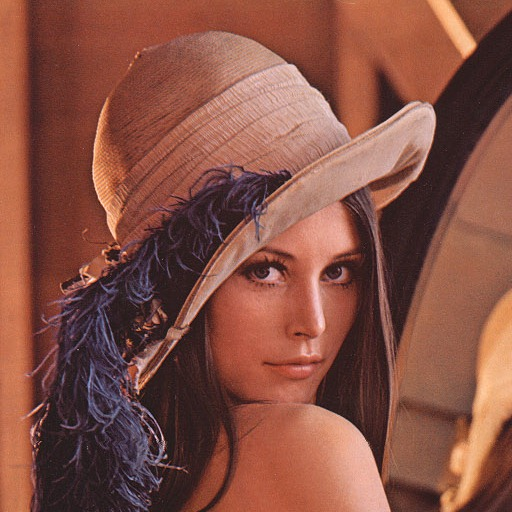

Emotion:happy


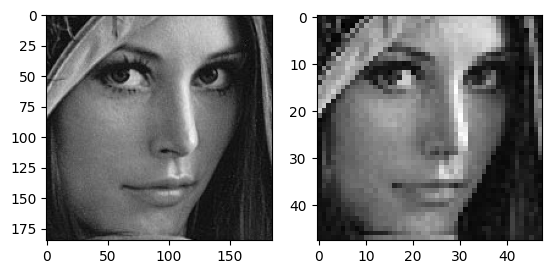

In [ ]:
img_dir = '/content/drive/MyDrive/PYTHON/CV/Baitap01/images/lena.jpg'
cv2_imshow(cv2.imread(img_dir, 1))
pred_emotion(lb_encoder, img_dir, mlp_jeff, 'mlp', 'image', 'dir')

In [ ]:
# from google.colab import files
# files.upload()

In [ ]:
# def detect_face_test(image_dir, model, lb_encoder):

#   frontalface_detector = dlib.get_frontal_face_detector()
#   img = cv2.imread(image_dir, 0)
#   img_rgb = cv2.imread(image_dir, -1)

#   rects = frontalface_detector(img, 1)
#   if len(rects) < 1:
#     print('No Face Detected')
#   else:
#     for(i, rect) in enumerate(rects):
#       (x, y, w, h) = rect_to_bb(rect)
#       cropped_img = crop_img(img, x, y, w, h)
#       cropped_img = cv2.resize(cropped_img, (48, 48))

#       img_rgb = cv2.rectangle(img_rgb, (x, y), (x+w, y+h), (0, 255, 0), 1)

#       text = lb_encoder.inverse_transform([predict_one(cropped_img, model, 'image', 'mlp')])[0]
#       scale = 0.12
#       font_scale = min(w, h)/(30/scale)
#       delta_x = int(x/(8/scale))
#       delta_y = int(y/(8/scale))
#       img_rgb = cv2.putText(img_rgb, text, (x+delta_x, y-delta_y), cv2.FONT_HERSHEY_SIMPLEX, font_scale, (0, 255, 0))
#   return img_rgb

In [ ]:
# plt.imshow(cv2.cvtColor(detect_face_test('/content/1.jpg', mlp_jeff, lb_encoder), cv2.COLOR_BGR2RGB))